# Anomaly Detection using fbProphet

In [2]:
!pip install fbprophet

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [5]:
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
df = df.set_index('timestamp').resample('H').mean()

In [8]:
df.head()

,value
timestamp,
2014-07-01 00:00:00,9485.5
2014-07-01 01:00:00,5433.0
2014-07-01 02:00:00,3346.5
2014-07-01 03:00:00,2216.5
2014-07-01 04:00:00,2189.5


In [9]:
fig = px.line(df.reset_index(), x='timestamp', y='value', title='NYC Taxi demand')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label='1y', step='year', stepmode='backward'),
                      dict(count=2, label='3y', step='year', stepmode='backward'),
                      dict(count=3, label='5y', step='year', stepmode='backward'),
                      dict(step='all')
                    ])
    )

)

fig.show()

In [10]:
from fbprophet import Prophet

In [11]:
taxi_df = df.reset_index()[['timestamp', 'value']].rename({'timestamp':'ds', 'value':'y'}, axis='columns')

In [12]:
taxi_df.head()

,ds,y
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


In [13]:
train = taxi_df[(taxi_df['ds'] >= '2014-07-01') & (taxi_df['ds'] <= '2015-01-27')]
test = taxi_df[(taxi_df['ds'] > '2015-01-27')] 

In [14]:
train.shape

(5041, 2)

In [15]:
test.shape

(119, 2)

In [16]:
m = Prophet(changepoint_range=0.95)

In [17]:
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [18]:
future = m.make_future_dataframe(periods=119, freq='H')
future.tail(5)

,ds
5155,2015-01-31 19:00:00
5156,2015-01-31 20:00:00
5157,2015-01-31 21:00:00
5158,2015-01-31 22:00:00
5159,2015-01-31 23:00:00


In [19]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5155,2015-01-31 19:00:00,23778.529213,19189.467384,29136.930247
5156,2015-01-31 20:00:00,24342.584334,19893.338315,28978.170125
5157,2015-01-31 21:00:00,23219.297735,18299.454490,27770.483902
5158,2015-01-31 22:00:00,21027.355314,16265.836769,25880.467423
5159,2015-01-31 23:00:00,18500.216845,13600.099250,23275.982151


In [20]:
results = pd.concat([taxi_df.set_index('ds')['y'], forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]], axis=1)

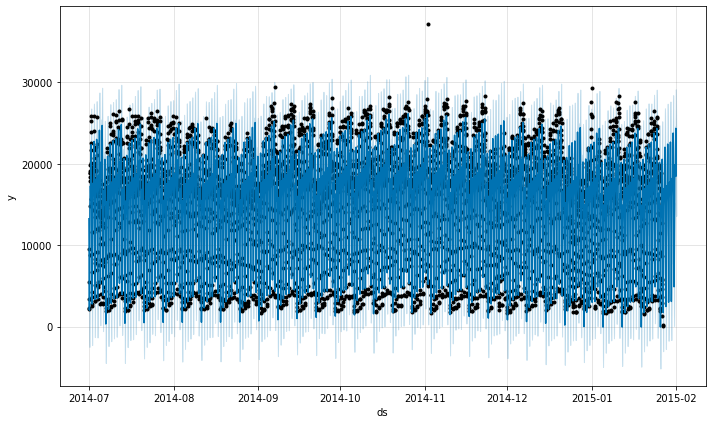

In [21]:
fig1 = m.plot(forecast)

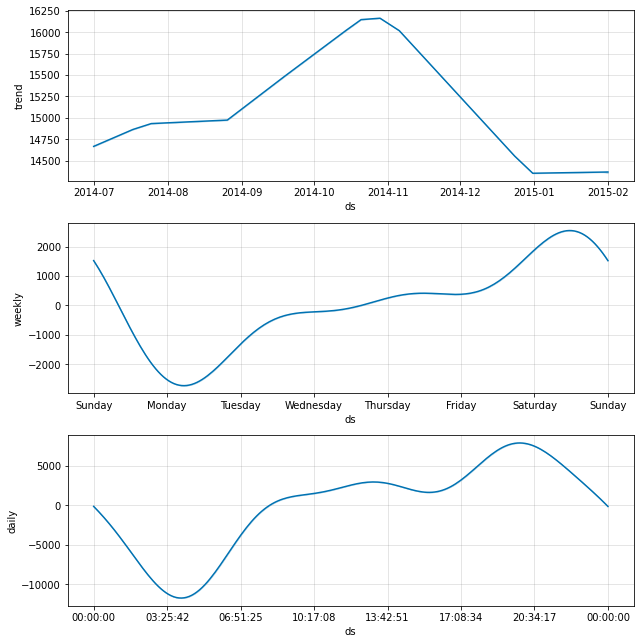

In [22]:
comp=m.plot_components(forecast)

In [23]:
results['error'] = results['y'] - results['yhat']

In [24]:
results['uncertainty'] = results['yhat_upper'] - results['yhat_lower']

In [25]:
results['anomaly'] = results.apply(lambda x: 'Yes' if(np.abs(x['error']) > 1.5*x['uncertainty']) else 'No', axis=1)

In [26]:
results[results['anomaly'] == 'Yes']

,y,yhat,yhat_lower,yhat_upper,error,uncertainty,anomaly
ds,,,,,,,
2014-11-02 01:00:00,37204.5,14218.892870,9345.997578,18749.714098,22985.607130,9403.716520,Yes
2015-01-01 01:00:00,29292.0,11405.545567,7068.699020,16508.301201,17886.454433,9439.602180,Yes
2015-01-01 02:00:00,25753.5,7770.054639,3132.837982,12771.082441,17983.445361,9638.244458,Yes
2015-01-01 03:00:00,22067.0,4478.895177,-115.338962,9471.700982,17588.104823,9587.039944,Yes
2015-01-26 19:00:00,4565.5,19771.308307,14918.182300,24794.804682,-15205.808307,9876.622382,Yes
2015-01-26 20:00:00,3630.5,20546.581743,15492.824993,25209.581486,-16916.081743,9716.756493,Yes
2015-01-26 21:00:00,2907.0,19647.710004,14954.830596,24523.681922,-16740.710004,9568.851326,Yes
2015-01-26 22:00:00,1324.5,17691.969234,12846.230666,22271.719379,-16367.469234,9425.488713,Yes
2015-01-26 23:00:00,243.0,15411.348672,10781.517550,20167.921973,-15168.348672,9386.404423,Yes


In [29]:
fig = px.line(results.reset_index(), x='ds', y='y', color='anomaly', title='NYC Taxi demand')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=1, label='1y', step='year', stepmode='backward'),
                      dict(count=2, label='3y', step='year', stepmode='backward'),
                      dict(count=3, label='5y', step='year', stepmode='backward'),
                      dict(step='all')
                    ])
    )

)

fig.show()

# Isolation Forest